This code was written by Evan Maxted for the final project for COMP 5114 - Quantum Communications and Networking at Carleton University taught by Michel Barbeau during the Winter 2025 semester.

The goal of this project was to evaluate quantum annealing as an approach for solving the NP-hard optimization travelling salesman problem. At the time of this project, quantum libraries such as qiskit and pyquil did not have enough memory to properly handle the amount of qubits required for solving the TSP.

This implementation uses the OpenJij SQASampler which performs simulated quantum annealing by using a Monte Carlo sweep. I found that the simulator showed very poor performance in solving the TSP, as it produces invalid paths and unbounded path costs.

There is reason to believe that true quantum hardware will produce better results.

The documentation for OpenJij along with a link to their GitHub can all be found at their website:
https://www.openjij.org/

In [20]:
import numpy as np
import tsplib95
import itertools
import matplotlib.pyplot as plt
from openjij import SQASampler

The Bellman-Held-Karp implementation was retrived from https://github.com/CarlEkerot/held-karp with the following copyright license

The MIT License (MIT)

Copyright (c) 2016 Carl Ekerot

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [21]:
def held_karp(dists):
    """
    Implementation of Held-Karp, an algorithm that solves the Traveling
    Salesman Problem using dynamic programming with memorization.

    Parameters:
        dists: distance matrix

    Returns:
        A tuple, (cost, path).
    """
    n = len(dists)

    # Maps each subset of the nodes to the cost to reach that subset, as well
    # as what node it passed before reaching this subset.
    # Node subsets are represented as set bits.
    C = {}

    # Set transition cost from initial state
    for k in range(1, n):
        C[(1 << k, k)] = (dists[0][k], 0)

    # Iterate subsets of increasing length and store intermediate results
    # in classic dynamic programming manner
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            # Set bits for all nodes in this subset
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            # Find the lowest cost to get to this subset
            for k in subset:
                prev = bits & ~(1 << k)

                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev, m)][0] + dists[m][k], m))
                C[(bits, k)] = min(res)

    # We're interested in all bits but the least significant (the start state)
    bits = (2**n - 1) - 1

    # Calculate optimal cost
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + dists[k][0], k))
    opt, parent = min(res)

    # Backtrack to find full path
    path = []
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits

    # Add implicit start state
    path.append(0)

    return opt, list(reversed(path))

In [ ]:
def build_tsp_ising(adj_matrix, A, B):
    '''
    Finds the Ising model coefficients h and J of the adjacency matrix. See Section V.B in the writeup for the origin of these loops

    Args:
        adj_matrix (numpy.ndarray): The adjacency matrix of the graph
        A (float): The strength of the Hamiltonian cycle constraints
        B (float): The strength of the edge cost constraint
    
    Returns:
        tuple (h, J):
        - h (numpy.ndarray): The local fields vector of coefficients
        - J (numpy.ndarray): The coupling terms matrix of coefficients
    '''
    n = adj_matrix.shape[0]
    h = np.zeros(n*n)
    J = np.zeros((n*n, n*n))

    # handle the city constraint (H_A1)
    for i in range(n):
        for j in range(n):
            index1 = i * n + j
            h[index1] += A / 2
            for k in range(j + 1, n):
                index2 = i * n + k
                h[index1] -= A / 2
                h[index2] -= A / 2
                J[index1, index2] -= A / 2
                J[index2, index1] -= A / 2

    # handle the position constraint (H_A2)
    for j in range(n):
        for i in range(n):
            index1 = i * n + j
            h[index1] += A / 2
            for k in range(i + 1, n):
                index2 = k * n + j
                h[index1] -= A / 2
                h[index2] -= A / 2
                J[index1, index2] -= A / 2
                J[index2, index1] -= A / 2

    # handle the edge cost constraint (H_B)
    for u in range(n):
        for v in range(n):
            if u != v:
                for i in range(n):
                    index1 = u * n + i
                    index2 = v * n + (i + 1) % n
                    h[index1] -= B / 4 * adj_matrix[u, v]
                    h[index2] -= B / 4 * adj_matrix[u, v]
                    J[index1, index2] -= B / 4 * adj_matrix[u, v]
                    J[index2, index1] -= B / 4* adj_matrix[u, v]

    return h, J

In [23]:
def simulate_qa(h, J, num_reads, num_sweeps):
    '''
    Simulates quantum annealing using OpenJij's SQASampler

    Args:
        h (numpy.ndarray): The local fields coefficients of the problem
        J (numpy.ndarray): The coupling terms coefficients of the problem
        num_reads (int): The number of times the sampler reruns
        num_sweeps (int): The annealing time (informally)
    
    Returns:
        sample (dict): The sample with the lowest energy from the sampling in spin form i.e. {-1, 1}
    '''
    sampler = SQASampler()

    h_dict = {i: -h[i] for i in range(len(h))}
    J_dict = {(i, j): -J[i, j] for i in range(len(J)) for j in range(i+1, len(J)) if J[i, j] != 0}

    response = sampler.sample_ising(h_dict, J_dict, num_reads=num_reads, num_sweeps=num_sweeps)
    return response.first.sample

In [ ]:
def extract_tsp_path(sample, n):
    '''
    Extracts the TSP path from the sample by converting it back to binary variables then placing cities accordingly

    Args:
        sample (dict): The dict of spins associated with the lowest energy path
        n (int): The number of nodes in the graph

    Returns
        path (list): The path of the TSP
    '''
    spins = np.array([sample[i] for i in range(len(sample))]) #convert spin dict to spin list
    map = ((1 + spins) // 2).reshape((n, n)) #convert spin back to binary

    path = []
    for pos in range(n):
        for city in range(n):
            if map[city, pos] == 1: #if x_ij = 1, city i is at position j in the tour
                path.append(city)
                break
            
    return path

In [25]:
def tsp_qa(adj, num_reads, num_sweeps):
    '''
    Takes an adjacency matrix and solves the TSP on it using simulated quantum annealing

    Args:
        adj (numpy.ndarray): The adjacency matrix of the graph
        num_reads (int): The number of times the annealer reruns
        num_sweeps (int): The annealing time (informally)
    
    Returns:
        path (list): The optimal path returned by the simulator
    '''
    A = 10*np.max(adj) #change this to adjust the strength of the Hamiltonian cycle constraints
    B = 1              #change this to adjust the strength of the edge cost constraint
    n = adj.shape[0]

    h, J = build_tsp_ising(adj, A, B)
    sample = simulate_qa(h, J, num_reads, num_sweeps)
    path = extract_tsp_path(sample, n)
    return path

In [26]:
def is_valid_tsp_path(path, n):
    '''Determines if a path forms a valid TSP'''
    return sorted(path) == list(range(n))

In [27]:
def tsp_tour_cost(path, adj_matrix):
    '''Determines the cost of a TSP tour'''
    cost = 0
    for i in range(len(path)):
        u = path[i]
        v = path[(i + 1) % len(path)]
        cost += adj_matrix[u][v]
    return cost

In [28]:
def generate_adj_matrix(graph, n):
    '''Generates an adjacency matrix for the given graph'''
    nodes = list(graph.get_nodes())[:n]
    adj = np.zeros((n, n))
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i != j:
                adj[i][j] = graph.get_weight(u, v)
    
    return adj

In [29]:
def is_metric_space(adj):
    '''Determines if the given adjacency matrix forms a metric space'''
    n = adj.shape[0]

    if not np.all(np.diag(adj) == 0):
        return False
    
    if not np.all(adj[np.triu_indices(n, k=1)] > 0):
        return False

    if not np.allclose(adj, adj.T):
        return False

    for i in range(n):
        for j in range(n):
            for k in range(n):
                if adj[i, j] > adj[i, k] + adj[k, j]:
                    return False

    return True

In [ ]:
problem_files = ["data/d2103.tsp", "data/pr107.tsp", "data/pr2392.tsp", "data/pr299.tsp"]
problems = ["d2103", "pr107", "pr2392", "pr299"]
#lower n or the parameters before testing because they take about 90 minutes as is
n_range = range(5,16)
num_reads = [1000, 100]
num_sweeps = [1000, 10000]
params = list(zip(num_reads, num_sweeps))

In [31]:
optimal_costs = {}
for i, problem_file in enumerate(problem_files):
    problem = tsplib95.load(problem_file)
    optimal_costs[problems[i]] = {}
    for n in n_range:
        adj = generate_adj_matrix(problem, n)
        
        optimal_cost, _ = held_karp(adj)
        optimal_costs[problems[i]][n] = optimal_cost

In [33]:
valid_path_counts = {}
valid_paths = {}
path_costs = {}

for i, problem_file in enumerate(problem_files):
    problem = tsplib95.load(problem_file)
    valid_paths[problems[i]] = {}
    path_costs[problems[i]] = {}

    for n in n_range:
        adj = generate_adj_matrix(problem, n)

        if i == 0:
            valid_path_counts[n] = {}
        valid_paths[problems[i]][n] = {}
        path_costs[problems[i]][n] = {}

        for read, sweep in params:
            path = tsp_qa(adj, read, sweep)
            valid = is_valid_tsp_path(path, n)

            if valid:
                cost = tsp_tour_cost(path, adj)
                path_costs[problems[i]][n][(read, sweep)] = cost
                valid_paths[problems[i]][n][(read, sweep)] = True
                if (read, sweep) not in valid_path_counts[n]:
                    valid_path_counts[n][(read, sweep)] = 0
                valid_path_counts[n][(read, sweep)] += 1

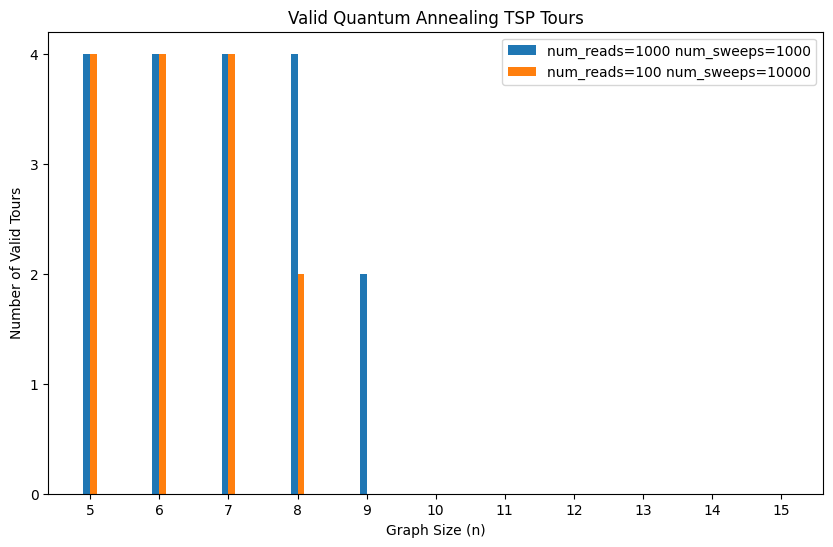

In [ ]:
plt.figure(figsize=(10, 6))
width = 0.1 
x_labels = list(n_range)
for i, param in enumerate(params):
    counts = [valid_path_counts[n].get(param, 0) for n in n_range]
    x_positions = [x + i * width for x in range(len(n_range))]
    plt.bar(x_positions, counts, width=width, label=f"num_reads={param[0]} num_sweeps={param[1]}")

plt.xlabel("Graph Size (n)")
plt.ylabel("Number of Valid Tours")
plt.title("Valid Quantum Annealing TSP Tours")
plt.xticks([x + width * (len(num_sweeps) - 1) / 2 for x in range(len(n_range))], x_labels)  # Center x-axis labels
plt.yticks(range(5))
plt.legend()

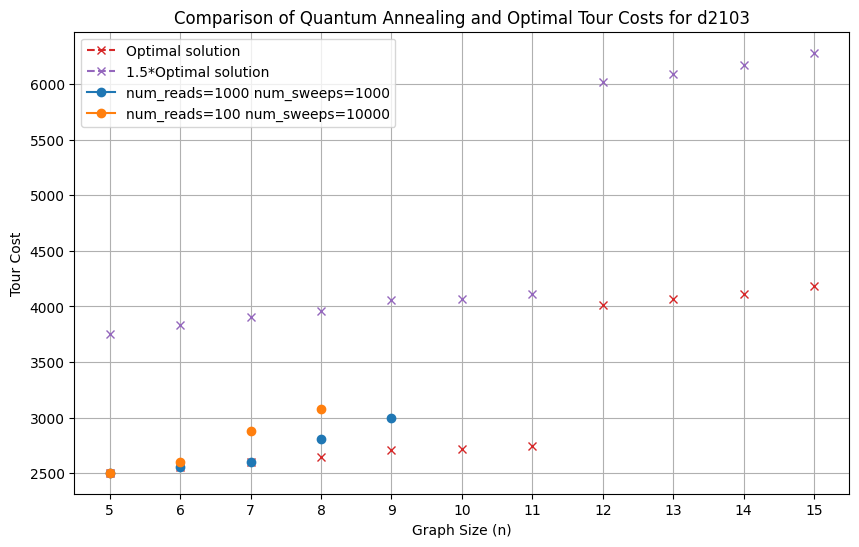

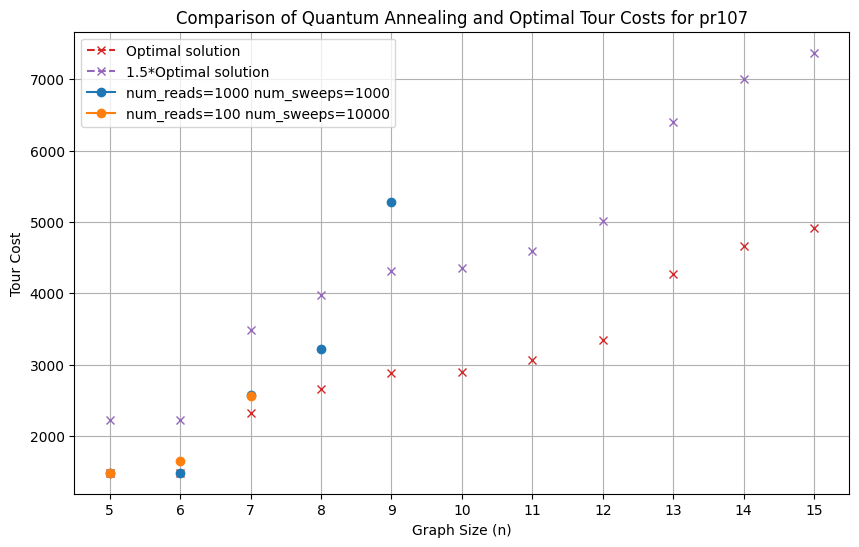

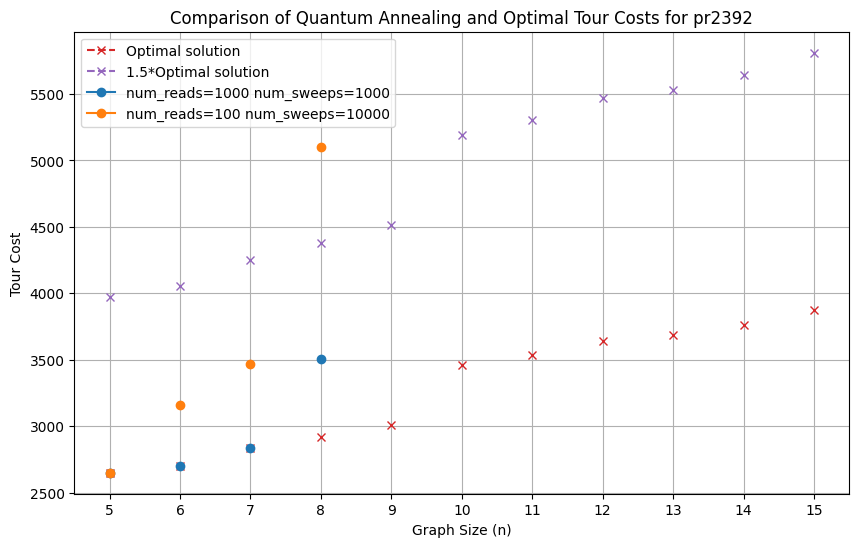

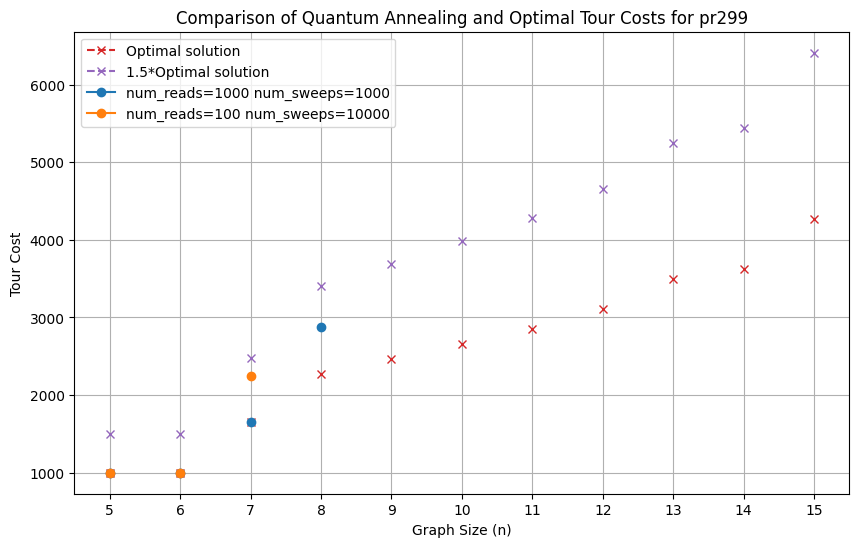

In [ ]:
for i, problem_file in enumerate(problem_files):
    plt.figure(figsize=(10,6))
    for n in n_range:
        plt.plot(n, optimal_costs[problems[i]][n], marker='x', color=f'C{3}', linestyle='--', label="Optimal solution" if n == 5 else "")
        plt.plot(n, 1.5*optimal_costs[problems[i]][n], marker='x', color=f'C{4}', linestyle='--', label="1.5*Optimal solution" if n == 5 else "")
        for j, param in enumerate(params):
            if valid_paths.get(problems[i], {}).get(n, {}).get(param, False):
                qa_cost = path_costs[problems[i]][n][param]
                plt.plot(n, qa_cost, marker='o', color=f'C{j}', label=f"num_reads={param[0]} num_sweeps={param[1]}" if n == 5 else "")
    plt.xlabel("Graph Size (n)")
    plt.ylabel("Tour Cost")
    plt.title(f"Comparison of Quantum Annealing and Optimal Tour Costs for {problems[i]}")
    plt.xticks(n_range)
    plt.legend()
    plt.grid(True)

    plt.show()